# Análisis del Riesgo de Obesidad y problemas CardioVasculares


# Carga de librerías y configuraciones

In [2]:
# warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Carga funciones propias reutilizables  de librerías
import os as so
import sys
utils_path = so.path.join(so.getcwd(), '..', 'utils')
sys.path.append(utils_path)

In [4]:
class PATH():
    RAW = '../data/raw//'
    PROCESSED= '../data/processed//'
    MODELS = '../models//'
    REPORTS = '../reports//'


In [5]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
import pandas as pd
import numpy as np


In [7]:
# pandas config
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# seaborn config
colors_palette=sns.color_palette('colorblind')

In [10]:

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [11]:
import python_clustering

In [12]:
from BorutaShap import BorutaShap

In [13]:
from utils import *

# EDA

## Carga datos


In [13]:
df_train = pd.read_csv(PATH.RAW + 'train.csv')
df_test = pd.read_csv(PATH.RAW +'test.csv')

## Significado de las columnas

Los atributos relacionados con los hábitos alimenticios son: 
- Consumo frecuente de alimentos altos en calorías (FAVC)
- Frecuencia de consumo de vegetales (FCVC)
- Número de comidas principales (NCP)
- Consumo de alimentos entre comidas (CAEC)
- Consumo de agua diario (CH20)
- Consumo de alcohol (CALC)

Los atributos relacionados con la condición física son: 
- Monitoreo del consumo de calorías (SCC)
- Frecuencia de actividad física (FAF)
- Tiempo utilizando dispositivos tecnológicos (TUE)
- Transporte utilizado (MTRANS)

Variables obtenidas: Género, Edad, Altura y Peso.

Los valores de NObesidad son:

- Bajo peso: Menos de 18.5
- Normal: 18.5 a 24.9
- Sobrepeso: 25.0 a 29.9
- Obesidad I: 30.0 a 34.9
- Obesidad II: 35.0 a 39.9
- Obesidad III: Más de 40

Los datos contienen datos numéricos y datos continuos, por lo que pueden ser utilizados para análisis basados en algoritmos de clasificación, predicción, segmentación y asociación.

## Objetivo
Tenemos que predecir el riesgo de obesidad en individuos.

## Descripción del conjunto de datos

| Columna                        | Forma completa                   | Descripción                                                                                                          |
|-------------------------------|----------------------------------|----------------------------------------------------------------------------------------------------------------------|
| 'id'                          | id                               | Único para cada persona (fila)                                                                                       |
| 'Gender'                      | Género                           | Género de la persona                                                                                                 |
| 'Age'                        | Edad                             | Dtype es float. La edad está entre 14 años y 61 años                                                                 |
| 'Height'                      | Altura                           | La altura está en metros, está entre 1,45 m y 1,98 m                                                                |
| 'Weight'                        | Peso                             | El peso está entre 39 y 165. Creo que está en Kg.                                                                   |
| 'family_history_with_overweight' | historia familiar con sobrepeso | pregunta de sí o no                                                                                                  |
| 'FAVC'                        | Consumo frecuente de alimentos altos en calorías | pregunta de sí o no. Creo que la pregunta que hicieron es si consumes alimentos altos en calorías                |
| 'FCVC'                        | Frecuencia de consumo de verduras | Similar a FAVC. También es una pregunta de sí o no                                                                  |
| 'NCP'                         | Número de comidas principales   | dtype es float, NCP está entre 1 y 4. Creo que debería ser 1,2,3,4 pero nuestros datos son sintéticos así que toma valores flotantes |
| 'CAEC'                        | Consumo de alimentos entre comidas | toma 4 valores: A veces, Frecuentemente, no y Siempre                                                              |
| 'SMOKE'                       | Fumar                            | pregunta de sí o no. Creo que la pregunta es "¿Fumas?"                                                              |
| 'CH2O'                        | Consumo de agua diario          | CH2O toma valores entre 1 y 3. de nuevo se da como flotante: los valores deberían ser 1,2 o 3 |
| 'SCC'                         | Monitoreo del consumo de calorías | pregunta de sí o no                                                                                                  |
| 'FAF'                         | Frecuencia de actividad física  | FAF está entre 0 y 3, 0 significa no hay actividad física y 3 significa un alto nivel de ejercicio. y nuevamente, en nuestros datos se da como flotante |
| 'TUE'                         | Tiempo utilizando dispositivos tecnológicos | TUE está entre 0 y 2. Creo que la pregunta será "¿Cuánto tiempo has estado usando dispositivos tecnológicos para rastrear tu salud?" en nuestros datos se da como flotante |
| 'CALC'                        | Consumo de alcohol              | Toma 3 valores: A veces, no, Frecuentemente                                                                          |
| 'MTRANS'                      | Transporte utilizado            | MTRANS toma 5 valores: Transporte Público, Automóvil, Caminar, Motocicleta y Bicicleta                            |
| 'NObeyesdad'                  | OBJETIVO                         | Objetivo, toma 7 valores, y en esta competencia tenemos que dar el nombre de la clase (No la Probabilidad, que es el caso en la mayoría de las competiciones). |


## Diccionarios

In [14]:
diccionario_columnas = {
    'FAVC': 'Consumo frecuente de alimentos altos en calorías',
    'FCVC': 'Frecuencia de consumo de vegetales',
    'NCP': 'Número de comidas principales',
    'CAEC': 'Consumo de alimentos entre comidas',
    'CH20': 'Consumo de agua diario',
    'CALC': 'Consumo de alcohol',
    'SCC': 'Monitoreo del consumo de calorías',
    'FAF': 'Frecuencia de actividad física',
    'TUE': 'Tiempo utilizando dispositivos tecnológicos',
    'MTRANS': 'Transporte utilizado',
    'Age':'Edad',
    'Height': 'Altura',
    'Weight':'Peso',
    'SMOKE':'Fumador',
    'Gender':'Género',
    'IMC':'Indice de Masa Corporal',
    'HA': 'Hábitos alimienticios',
    'UT': 'Uso de Tecnología',
    'family_history_with_overweight':'Historial familiar con sobrepeso'
}


## Target
   

In [15]:
target = "NObeyesdad"

In [16]:
dict_target={'Insufficient_Weight': 0,
 'Normal_Weight': 1,
 'Overweight_Level_I': 2,
 'Overweight_Level_II': 3,
  'Obesity_Type_I': 4,
 'Obesity_Type_II': 5,
 'Obesity_Type_III': 6,}


In [17]:
dictrev_target={v:k for k,v in  dict_target.items()}


1.3 Vistazo rápido

In [18]:
df=df_train.copy()

In [19]:
df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.44,1.70,81.67,yes,yes,2.00,2.98,Sometimes,no,2.76,no,0.00,0.98,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.00,1.56,57.00,yes,yes,2.00,3.00,Frequently,no,2.00,no,1.00,1.00,no,Automobile,Normal_Weight
2,2,Female,18.00,1.71,50.17,yes,yes,1.88,1.41,Sometimes,no,1.91,no,0.87,1.67,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.95,1.71,131.27,yes,yes,3.00,3.00,Sometimes,no,1.67,no,1.47,0.78,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.64,1.91,93.80,yes,yes,2.68,1.97,Sometimes,no,1.98,no,1.97,0.93,Sometimes,Public_Transportation,Overweight_Level_II


In [20]:
df.tail()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
20753,20753,Male,25.14,1.77,114.19,yes,yes,2.92,3.00,Sometimes,no,2.15,no,1.33,0.20,Sometimes,Public_Transportation,Obesity_Type_II
20754,20754,Male,18.00,1.71,50.00,no,yes,3.00,4.00,Frequently,no,1.00,no,2.00,1.00,Sometimes,Public_Transportation,Insufficient_Weight
20755,20755,Male,20.10,1.82,105.58,yes,yes,2.41,3.00,Sometimes,no,2.00,no,1.16,1.20,no,Public_Transportation,Obesity_Type_II
20756,20756,Male,33.85,1.70,83.52,yes,yes,2.67,1.97,Sometimes,no,2.14,no,0.00,0.97,no,Automobile,Overweight_Level_II
20757,20757,Male,26.68,1.82,118.13,yes,yes,3.00,3.00,Sometimes,no,2.00,no,0.68,0.71,Sometimes,Public_Transportation,Obesity_Type_II


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [22]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,20758.00,NaN,NaN,NaN,10378.50,5992.46,0.00,5189.25,10378.50,15567.75,20757.00
Gender,20758,2,Female,10422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,20758.00,NaN,NaN,NaN,23.84,5.69,14.00,20.00,22.82,26.00,61.00
Height,20758.00,NaN,NaN,NaN,1.70,0.09,1.45,1.63,1.70,1.76,1.98
Weight,20758.00,NaN,NaN,NaN,87.89,26.38,39.00,66.00,84.06,111.60,165.06
family_history_with_overweight,20758,2,yes,17014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAVC,20758,2,yes,18982,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FCVC,20758.00,NaN,NaN,NaN,2.45,0.53,1.00,2.00,2.39,3.00,3.00
NCP,20758.00,NaN,NaN,NaN,2.76,0.71,1.00,3.00,3.00,3.00,4.00
CAEC,20758,4,Sometimes,17529,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
data_report(df)

COL_N,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
DATA_TYPE,int64,object,float64,float64,float64,object,object,float64,float64,object,object,float64,object,float64,float64,object,object,object
MISSINGS (%),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
UNIQUE_VALUES,20758,2,1703,1833,1979,2,2,934,689,4,2,1506,2,1360,1297,3,5,7
CARDIN (%),100.00,0.01,8.20,8.83,9.53,0.01,0.01,4.50,3.32,0.02,0.01,7.26,0.01,6.55,6.25,0.01,0.02,0.03


Highlights: Sin missings, no tiene mucha cardinalidad.

In [24]:
contains_inf = df.isin([np.inf, -np.inf]).any().any()
contains_inf

False

No hay infinitos

In [25]:
duplicados = df.duplicated().any()
duplicados

False

Sin duplicados

In [26]:
categoricas = df.columns[df.dtypes=="object"].tolist()
numericas = df.columns[df.dtypes!="object"].tolist()

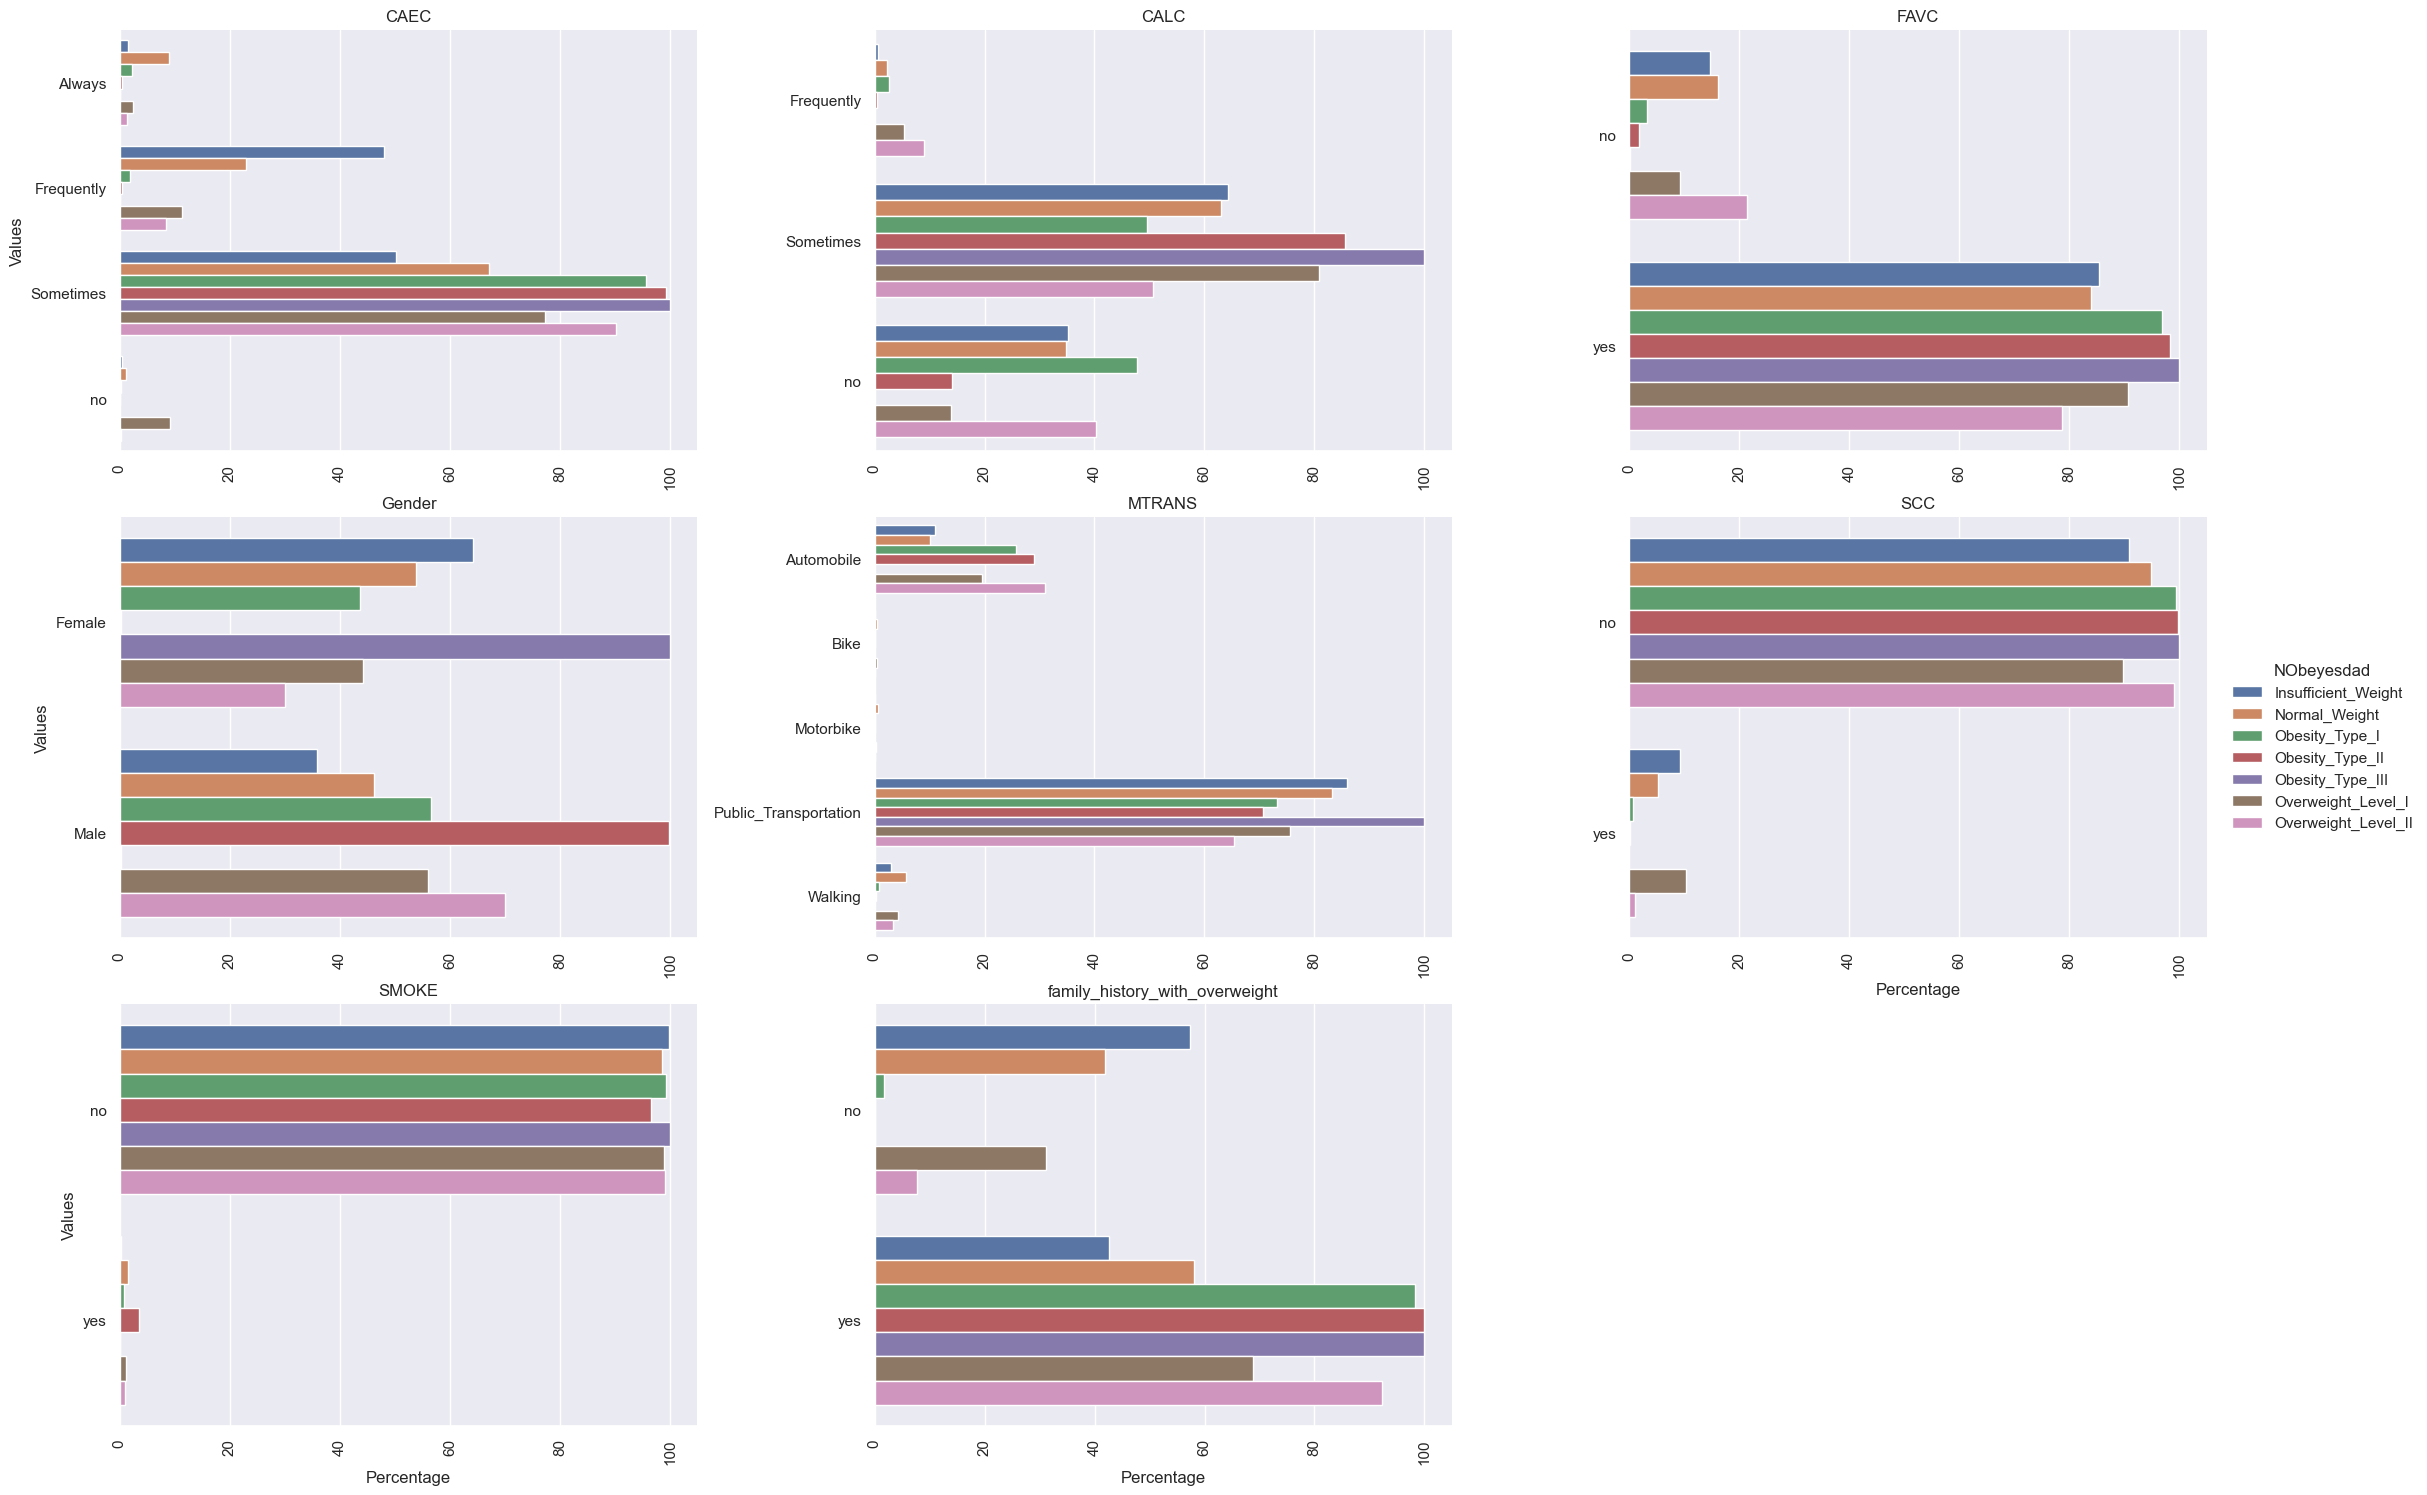

In [27]:
plot_tidy_categorical(df, categoricas, target)

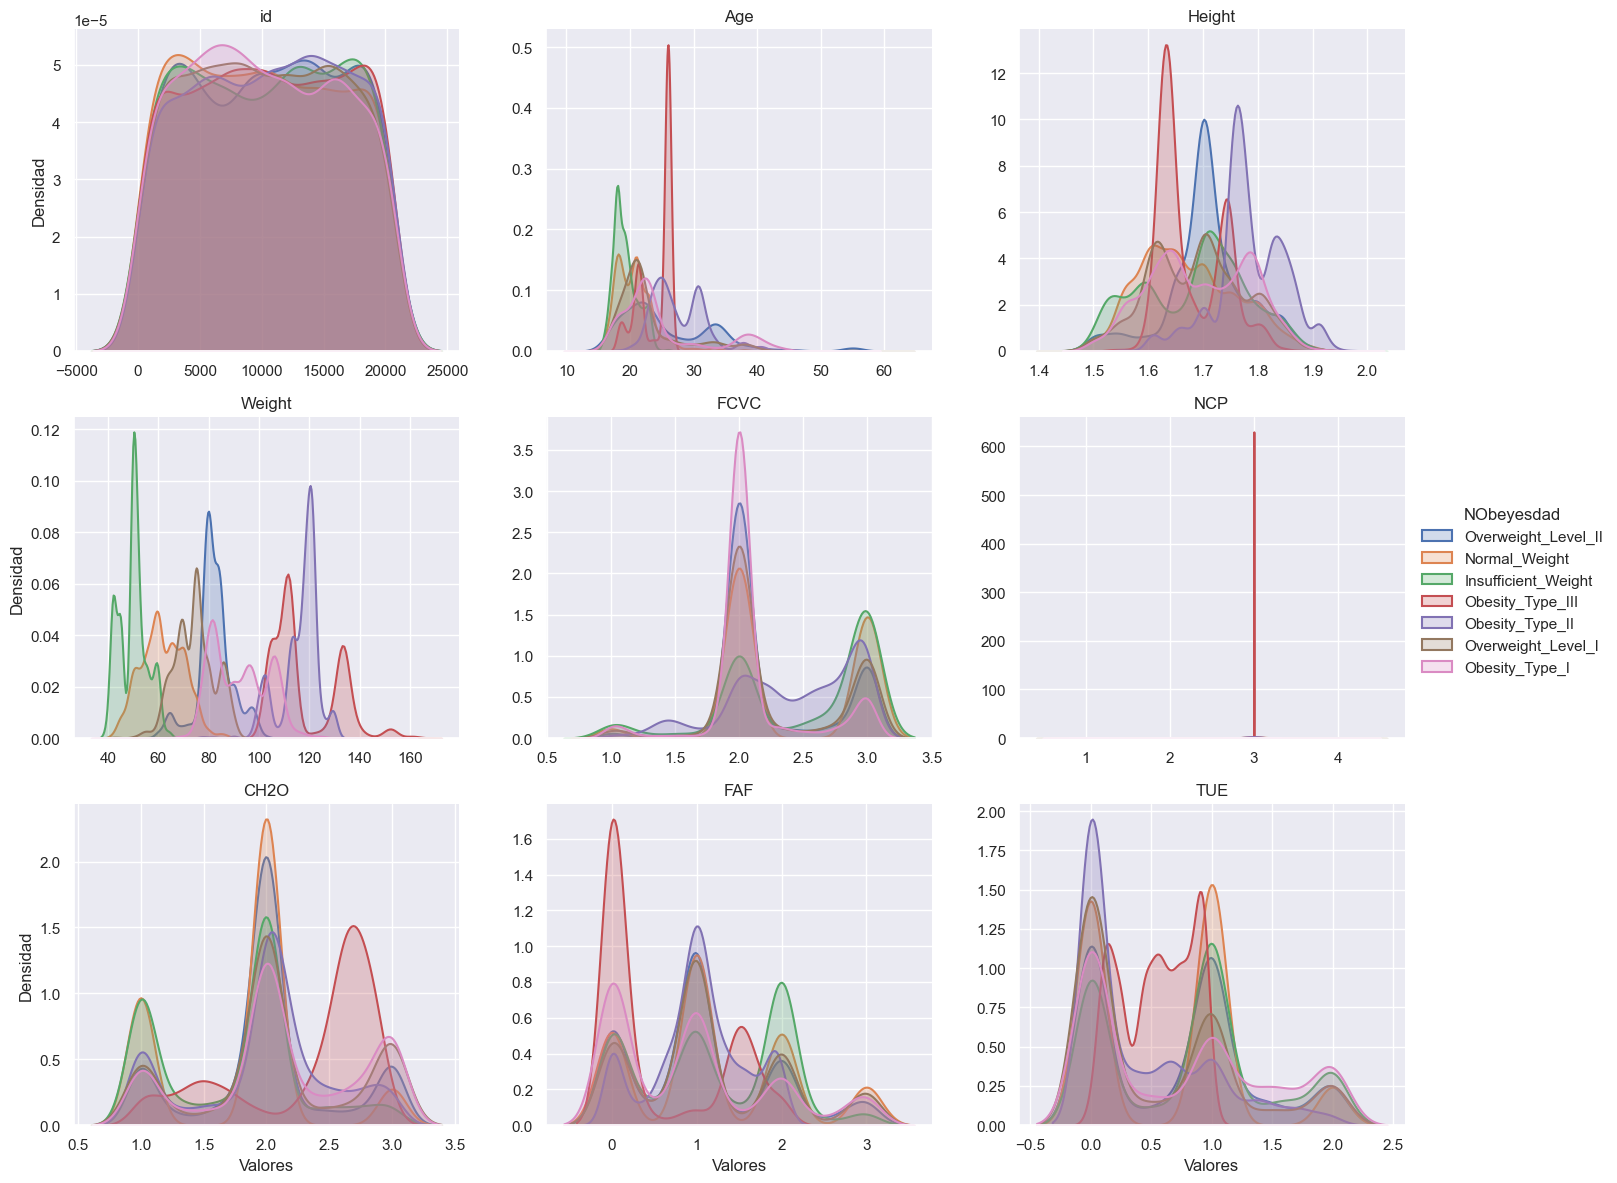

In [28]:
plot_tidy(df, numericas, target)

# Problema Machine Learning
   

In [29]:
df[target].value_counts() / len(df[target])

NObeyesdad
Obesity_Type_III      0.19
Obesity_Type_II       0.16
Normal_Weight         0.15
Obesity_Type_I        0.14
Insufficient_Weight   0.12
Overweight_Level_II   0.12
Overweight_Level_I    0.12
Name: count, dtype: float64

Al examinar la distribución del objetivo, podemos deducir lo siguiente:

- Se trata de un problema de clasificación múltiple, con 7 clases.
- Las clases están distribuidas de manera diferente, pero no hay diferencias extremas en sus proporciones (probabilidad media).
- Sin embargo, la clase más frecuente (Obesidad_Tipo_III) tiene casi el doble de probabilidad que la menos frecuente (Sobrepeso_Nivel_I). Por lo tanto, al definir la estrategia de validación cruzada, será estratificada  para que las diferentes probabilidades previas se reflejen lo más exactamente posible también en el conjunto de prueba.

# Feature Engineering


![](https://www.stylecraze.com/wp-content/themes/buddyboss-child/images/man-body-mass-index-vector.jpg)

Índice de Masa Corporal (IMC):
Utilizando las características de 'Altura' y 'Peso'. El IMC, una métrica ampliamente reconocida, indica la obesidad al proporcionar una representación más precisa de la relación entre el peso y la altura de un individuo.

Hábitos Alimenticios (HA):
La combinación de 'FCVC' (Frecuencia de consumo de vegetales) y 'NCP' (Número de comidas principales) creó la característica 'Hábitos_Alimenticios'. Esta característica busca encapsular los patrones dietéticos generales, considerando tanto la frecuencia de consumo de vegetales como el número de comidas principales.

Puntuación de Uso de Tecnología (UT):
Se creó una puntuación integral ponderando la frecuencia de uso de la tecnología ('UT') por la edad del individuo. La puntuación resultante de 'Uso_de_Tecnología' tiene como objetivo cuantificar el tiempo promedio que se pasa utilizando la tecnología en relación con la edad de la persona, proporcionando una perspectiva matizada sobre los hábitos tecnológicos.

Hay columnas que tienen orden y que deben convertirse a variables discretas. Las mapeo también.

In [30]:
dict_CAEC={
    'no': 0,
    'Sometimes': 1,
    'Frequently': 2,
    'Always': 3}
dict_CALC={
    'no': 0,
    'Sometimes': 1,
    'Frequently': 2,
    'Always': 3}

In [31]:
def Feature_Engineering(df):
    df.set_index('id', inplace=True)
    df['IMC'] = df['Weight'] / (df['Height'] ** 2)
    df['HA'] = df['FCVC'] * df['NCP']
    df['UT'] = df['TUE'] / df['Age']
    df['CALC']=df['CALC'].map(dict_CALC)
    df['CAEC']=df['CAEC'].map(dict_CAEC)
    return df

In [32]:
df_train = Feature_Engineering(df_train)
df_test = Feature_Engineering(df_test)
df = Feature_Engineering(df)
numericas = df.columns[df.dtypes!="object"].tolist()

In [33]:
diccionario_columnas = {
    'FAVC': 'Consumo frecuente de alimentos altos en calorías',
    'FCVC': 'Frecuencia de consumo de vegetales',
    'NCP': 'Número de comidas principales',
    'CAEC': 'Consumo de alimentos entre comidas',
    'CH20': 'Consumo de agua diario',
    'CALC': 'Consumo de alcohol',
    'SCC': 'Monitoreo del consumo de calorías',
    'FAF': 'Frecuencia de actividad física',
    'TUE': 'Tiempo utilizando dispositivos tecnológicos',
    'MTRANS': 'Transporte utilizado',
    'Age':'Edad',
    'Height': 'Altura',
    'Weight':'Peso',
    'SMOKE':'Fumador',
    'Gender':'Género',
    'IMC':'Indice de Masa Corporal',
    'HA': 'Hábitos alimienticios',
    'UT': 'Uso de Tecnología',
    'family_history_with_overweight':'Historial familiar con sobrepeso'
}


In [34]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,IMC,HA,UT
id,,,,,,,,,,,,,,,,,,,,
0,Male,24.44,1.70,81.67,yes,yes,2.00,2.98,1,no,2.76,no,0.00,0.98,1,Public_Transportation,Overweight_Level_II,28.26,5.97,0.04
1,Female,18.00,1.56,57.00,yes,yes,2.00,3.00,2,no,2.00,no,1.00,1.00,0,Automobile,Normal_Weight,23.42,6.00,0.06
2,Female,18.00,1.71,50.17,yes,yes,1.88,1.41,1,no,1.91,no,0.87,1.67,0,Public_Transportation,Insufficient_Weight,17.13,2.65,0.09
3,Female,20.95,1.71,131.27,yes,yes,3.00,3.00,1,no,1.67,no,1.47,0.78,1,Public_Transportation,Obesity_Type_III,44.86,9.00,0.04
4,Male,31.64,1.91,93.80,yes,yes,2.68,1.97,1,no,1.98,no,1.97,0.93,1,Public_Transportation,Overweight_Level_II,25.60,5.28,0.03


# Análisis univariante


In [ ]:
categoricas = df.columns[df.dtypes=="object"].tolist()
numericas = df.columns[df.dtypes!="object"].tolist()

In [ ]:
plot_horizontal_catplot(df, categoricas, diccionario_columnas)

In [ ]:
df[target]=df[target].map(dict_target)

In [ ]:
for col in numericas:
    plot_distribucion(df,col, title=diccionario_columnas.get(col, col))

# Análisis bivariante


In [ ]:
sns.set_theme(style='white')
sns.pairplot(df,kind="reg",diag_kind='kde',plot_kws={'line_kws':{'color':'red'}},corner=True,hue=target)
plt.tight_layout()
plt.show()


In [ ]:
for col in numericas:
    plot_analysis(df,target,col)


# Eliminación de features


In [ ]:
df = drop_cols(df, max_cardi=20, max_miss=30)

# Correlación

In [ ]:
import phik
phik_matrix = df.phik_matrix()

plt.figure(figsize=(25,10))
sns.heatmap(phik_matrix,
            vmin=0,
            vmax=1,
            center=0,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=10),
            square=True,
            annot=True,
            linewidths=.5);

# Anomalías y errores


No se han encontrado a la vista.
Se toman como anomalía los outliners que luego se detecten.


# Transformaciones (Encoding)
    

In [ ]:
def sqrt_transform(X):
    return np.sqrt(X)

def log_transform(X):
    return np.log1p(X)

In [ ]:
classify_distributions(df, threshold=0.05)

In [ ]:
df.head()

In [ ]:
# target no necesita transformación
y = df[target]

Guardo df, df_train y df_test antes de transformarlas

In [ ]:
# Save df as pickle
df.to_pickle(PATH.PROCESSED + 'df.pkl')
df_train.to_pickle(PATH.PROCESSED + 'df_train.pkl')
df_test.to_pickle(PATH.PROCESSED + 'df_test.pkl')

In [ ]:
# Load df as pickle
df = pd.read_pickle(PATH.PROCESSED + 'df.pkl')
df_train = pd.read_pickle(PATH.PROCESSED + 'df_train.pkl')
df_test = pd.read_pickle(PATH.PROCESSED + 'df_test.pkl')

Pipeline para transformar las columnas. Para ver la significancia, lo tengo que pasar a numéricas y ya veré si posteriormente elimino columnas antes de quitar outliners.

In [ ]:
dist_class = classify_distributions(df, threshold=0.05)

In [ ]:
list(df.select_dtypes(include=['number']).columns)


In [ ]:
def Encoder(df, target_col, threshold=0.05):
    if target_col not in df.columns:
        X = df.copy()
    else:
        X = df.drop(columns=[target_col])

    dist_class = classify_distributions(X, threshold)
    
    categorical_columns = list(X.select_dtypes(include=['object']).columns)

    if categorical_columns:
        categorical_pipeline = Pipeline([
            ('onehot', OneHotEncoder(drop='first'))
        ])
    else:
        categorical_pipeline = None
    
    numeric_columns_to_transform = [col for col, (dist,model) in dist_class.items()]
    untouched_columns = list(set(X.columns) - set(categorical_columns) - set(numeric_columns_to_transform))

    numeric_transformers = [
        ('sqrt_transform', FunctionTransformer(sqrt_transform), [col for col, (dist, _) in dist_class.items() if dist == 'positive_increasing']),
        ('log_transform', FunctionTransformer(log_transform), [col for col, (dist, _) in dist_class.items() if dist == 'positive_decreasing']),
        ('yeojohnson_transform', PowerTransformer(method='yeo-johnson'), [col for col, (dist, _) in dist_class.items() if dist not in ['positive_increasing', 'positive_decreasing']]),
        ('untouched', 'passthrough', untouched_columns)
    ]

    numeric_pipeline = Pipeline([
        ('transformation', ColumnTransformer(
            transformers=numeric_transformers,
            remainder='passthrough')
        ),
        ('scaler', StandardScaler())
    ])

    if categorical_pipeline:
        preprocessor = ColumnTransformer([
            ('categorical', categorical_pipeline, categorical_columns),
            ('numeric', numeric_pipeline, numeric_columns_to_transform)
        ])
    else:
        preprocessor = numeric_pipeline

    final_pipeline = Pipeline([
        ('preprocessor', preprocessor)
    ])

    required_columns = set([col for col, _ in dist_class.items()])
    if not required_columns.issubset(X.columns):
        missing_columns = required_columns - set(X.columns)
        raise ValueError(f"Missing columns: {missing_columns}")

    X_trans = final_pipeline.fit_transform(X)
    transformed_columns = []

    # Obtener columnas transformadas de OHE
    if categorical_columns:
        ohe_columns = final_pipeline.named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out()
        transformed_columns.extend(ohe_columns)

    # Obtener columnas transformadas de variables numéricas
    numeric_transformer = final_pipeline.named_steps['preprocessor'].named_transformers_['numeric'].named_steps['transformation']
    numeric_columns_transformed = [col for name, transformer, col in numeric_transformer.transformers_ if transformer != 'drop']
    transformed_columns.extend(numeric_columns_transformed)

    # Obtener columnas restantes
    remaining_columns = list(X.columns.difference(categorical_columns + numeric_columns_to_transform))
    transformed_columns.extend(remaining_columns)
    transformed_columns=list(pd.DataFrame(transformed_columns)[0].explode().dropna())
    
    return pd.DataFrame(X_trans, columns=transformed_columns)


    


In [ ]:
X_trans=Encoder(df, target, threshold=0.05)
X_test=Encoder(df_test, target, threshold=0.05)

# 3. División train y test
   

En la división aprovecho a quitar los outliiers para trabajos los modelos baselines

In [ ]:
from pyod.models.ecod import ECOD

In [ ]:
def outlier_split(X_trans,y, test_size=0.2):
    Xout=X_trans.copy()
    outclf = ECOD(n_jobs=-1)
    outclf.fit(Xout)
    mask = outclf.labels_  # binary labels (0: inliers, 1: outliers)
    X_trans_out=X_trans[mask==0]
    X_trans_out=pd.DataFrame(data=X_trans_out, columns=X_trans.columns)
    y_out=[y for  i,y in enumerate(y) if mask[i]==0]
    X_train, X_val, y_train, y_val = train_test_split(X_trans_out, y_out, test_size=test_size, random_state=123)
    return X_train, X_val, y_train, y_val

In [ ]:
X_train, X_val, y_train, y_val=outlier_split(X_trans,y, test_size=0.2)

In [ ]:
trainval=['X_train', 'X_val','y_train', 'y_val']
for data in trainval:
    if  isinstance(data,pd.DataFrame):
        globals()[data]=reduce_memory_usage(globals()[data])
    else:
        globals()[data]=reduce_memory_usage(pd.DataFrame((globals()[data])))

In [ ]:
# Guardar X_train, X_val, y_train, y_val
X_train.to_pickle(PATH.PROCESSED + 'X_train.pkl')
X_val.to_pickle(PATH.PROCESSED + 'X_val.pkl')
y_train.to_pickle(PATH.PROCESSED + 'y_train.pkl')
y_val.to_pickle(PATH.PROCESSED + 'y_val.pkl')

In [14]:
# Leer X_train, X_val, y_train, y_val
X_train = pd.read_pickle(PATH.PROCESSED + 'X_train.pkl')
X_val = pd.read_pickle(PATH.PROCESSED + 'X_val.pkl')
y_train = pd.read_pickle(PATH.PROCESSED + 'y_train.pkl')
y_val = pd.read_pickle(PATH.PROCESSED + 'y_val.pkl')


# 15. Feature Reduction


In [18]:
import random

def generate_random_numbers(dataframe_length, num_numbers=2000):
    return [random.randint(0, dataframe_length - 1) for _ in range(num_numbers)]


Por cuestión de tiempo de computación  no hago análsiis de todo el DataFrame. En su defecto, hago un random sample mayor del 10% de la muestra y lo tomo como representativo.

In [19]:
generate_random_numbers=generate_random_numbers(len(X_train),num_numbers=2000)
X_train_=X_train.iloc[generate_random_numbers]
y_train_=y_train.iloc[generate_random_numbers]

  0%|          | 0/100 [00:00<?, ?it/s]

16 attributes confirmed important: ['Height', 'Age', 'HA', 'TUE', 'MTRANS_Public_Transportation', 'CH2O', 'CAEC', 'Weight', 'FAF', 'FCVC', 'IMC', 'UT', 'NCP', 'CALC', 'Gender_Male', 'family_history_with_overweight_yes']
6 attributes confirmed unimportant: ['SCC_yes', 'SMOKE_yes', 'MTRANS_Bike', 'MTRANS_Walking', 'FAVC_yes', 'MTRANS_Motorbike']
0 tentative attributes remains: []
0 tentative features are now accepted: []
0 tentative features are now rejected: []


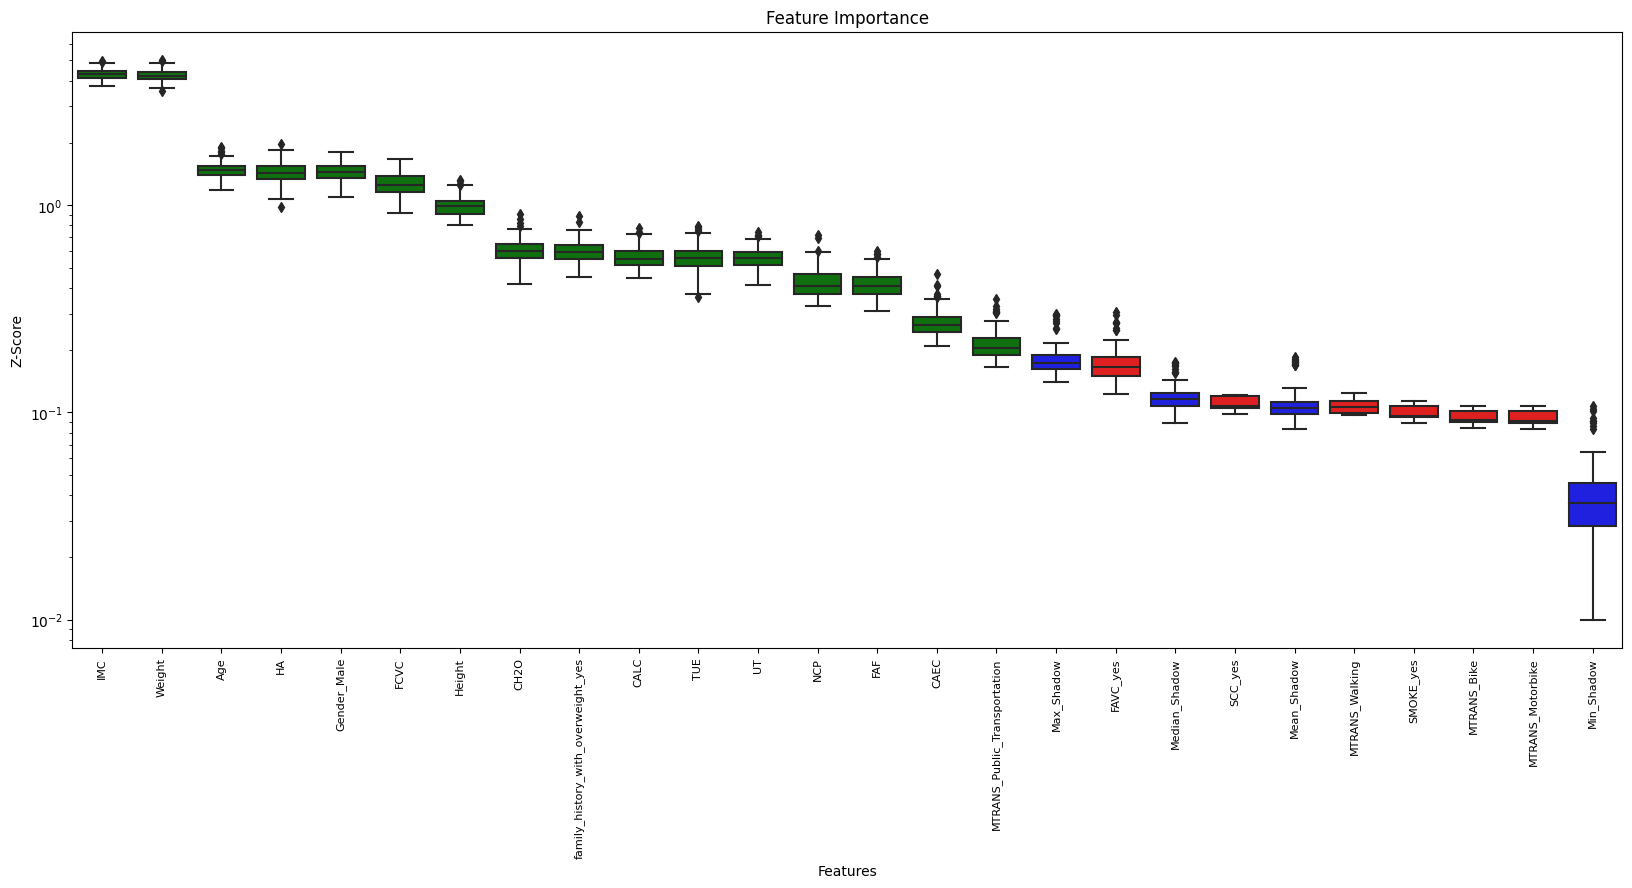

['Age',
 'CAEC',
 'CALC',
 'CH2O',
 'FAF',
 'FCVC',
 'Gender_Male',
 'HA',
 'Height',
 'IMC',
 'MTRANS_Public_Transportation',
 'NCP',
 'TUE',
 'UT',
 'Weight',
 'family_history_with_overweight_yes']

In [20]:
selvars=selvars_boruta(X_train_,y_train_,isclass=True,n_trials=100)
selvars

In [21]:
selvars=['Age',
 'CAEC',
 'CALC',
 'CH2O',
 'FAF',
 'FCVC',
 'Gender_Male',
 'HA',
 'Height',
 'IMC',
 'MTRANS_Public_Transportation',
 'NCP',
 'TUE',
 'UT',
 'Weight',
 'family_history_with_overweight_yes']

Tengo que validar que con el 10% de las columnas elegidas representan el conjunto del DataFrame de las columnas. 
Para ello hago un test de  Kolmogorov-Smirnov con cross validation para cada una de las columnas

In [54]:
from scipy import stats
from sklearn.model_selection import KFold

def test_distribution_cv(dataframe, perfrac=0.01, columns=None, n_trials=10):
    sample = X_train.sample(frac=perfrac)
    kf = KFold(n_splits=n_trials, shuffle=True, random_state=42)
    results = []

    if columns is None:
        columns = dataframe.columns

    for column_name in columns:
        equal_distributions = 0

        for train_index, test_index in kf.split(dataframe):
            train_data = dataframe.iloc[train_index]
            test_data = sample.sample(len(train_data), replace=True)

            # Realizar la prueba de Kolmogorov-Smirnov
            statistic, p_value = stats.ks_2samp(train_data[column_name], test_data[column_name])

            # Interpretar el resultado
            if p_value > 0.05:
                equal_distributions += 1  # Contar distribuciones iguales

        # Calcular el porcentaje de distribuciones iguales
        percent_equal_distributions = (equal_distributions / n_trials) * 100
        results.append({"Columna": column_name, f"Perc_igual_dist_"+str(perfrac): percent_equal_distributions})

    # Convertir la lista de resultados en un DataFrame
    results_df = pd.DataFrame(results)
    return results_df





In [71]:
results = test_distribution_cv(X_train, perfrac=0.45, columns=selvars, n_trials=10)

In [72]:
results

,Columna,Perc_igual_dist_0.45
0,Age,80.00
1,CAEC,100.00
2,CALC,100.00
3,CH2O,100.00
4,FAF,100.00
5,FCVC,100.00
6,Gender_Male,100.00
7,HA,100.00
8,Height,90.00
9,IMC,100.00


Hay que recalcular el Boruta para el 45% de la muestra

In [ ]:
X_train.isna().sum()

<AxesSubplot: xlabel='pca_2', ylabel='pca_1'>

Text(0.5, 1.0, 'Top 2 Principal Components')

KMeans(n_clusters=7, random_state=0)

<AxesSubplot: xlabel='pca_2', ylabel='pca_1'>

Text(0.5, 1.0, 'Kmeans en Top 2 Principal Components')

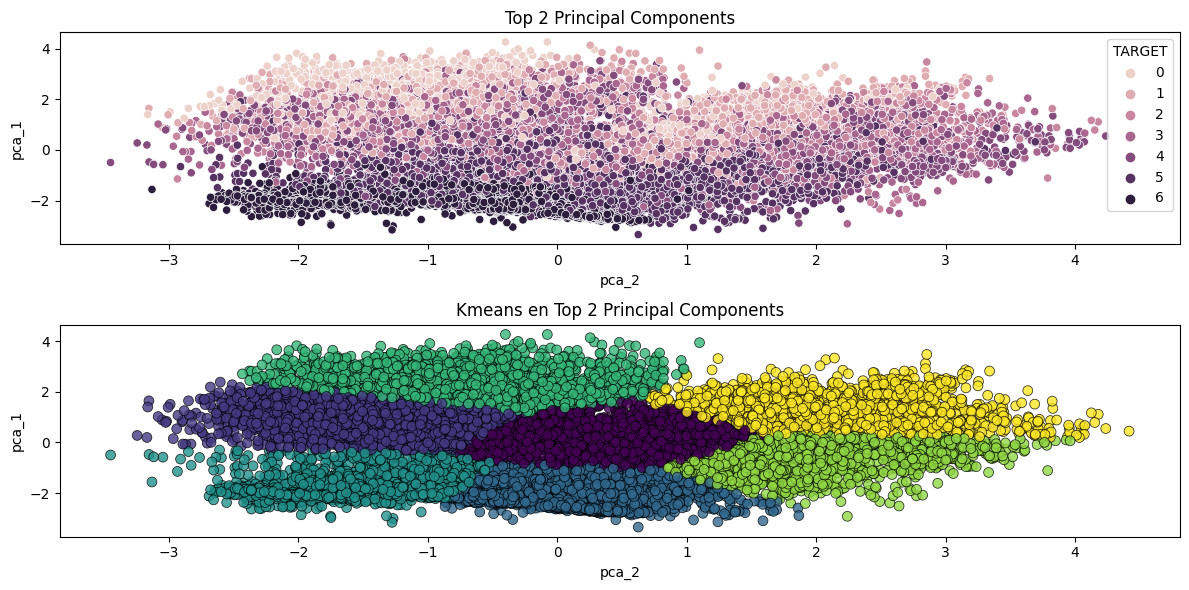

In [75]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#PCA
pca = PCA(n_components=2)
pca_top_2 = pca.fit_transform(X_train[selvars])

tmp = pd.DataFrame(data = pca_top_2, columns = ['pca_1','pca_2'])
tmp['TARGET'] = y_train

fig,axs = plt.subplots(2,1,figsize = (12,6))
sns.scatterplot(data=tmp, y="pca_1", x="pca_2", hue='TARGET',ax=axs[0])
axs[0].set_title("Top 2 Principal Components")

#KMeans
kmeans = KMeans(7,random_state=0)
kmeans.fit(tmp[['pca_1','pca_2']])
sns.scatterplot( y= tmp['pca_1'],x = tmp['pca_2'],c = kmeans.labels_,cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.8,ax = axs[1])
axs[1].set_title("Kmeans en Top 2 Principal Components")
plt.tight_layout()
plt.show()

Está completamente clusterizado sin outliers

# Escoger métrica del modelo


## Métricas de clasificación

Recall (Sensibilidad o Tasa de Verdaderos Positivos): Es la proporción de verdaderos positivos sobre el total de instancias que son realmente positivas. Se calcula como TP / (TP + FN).

 
Es útil por que no quiero dejar fuera a aquellas personas que sufran riesgo de enfermedad y no sean tratadas convenientemente ( quiero evitar falsos negativos).

# Baselines


In [76]:
# Modelos de Clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
#Meter CatBoost

In [77]:

# Definir los modelos a comparar
modelos = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'Support Vector Machine': SVC(gamma='scale', probability=True),
    'Naive Bayes': GaussianNB(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Bagging': BaggingClassifier(n_estimators=10),
    'Extra Trees': ExtraTreesClassifier(n_estimators=10),
    #'XGBoost': XGBClassifier(),
    'Random Forest':RandomForestClassifier(n_estimators=10),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'LightGBM':LGBMClassifier(),
}


In [ ]:
# Factores que influyen en esta decisión


In [79]:
# Reduzco el modelo a las variables seleccionadas
X_train_fs=X_train[selvars]
X_val_fs=X_val[selvars]

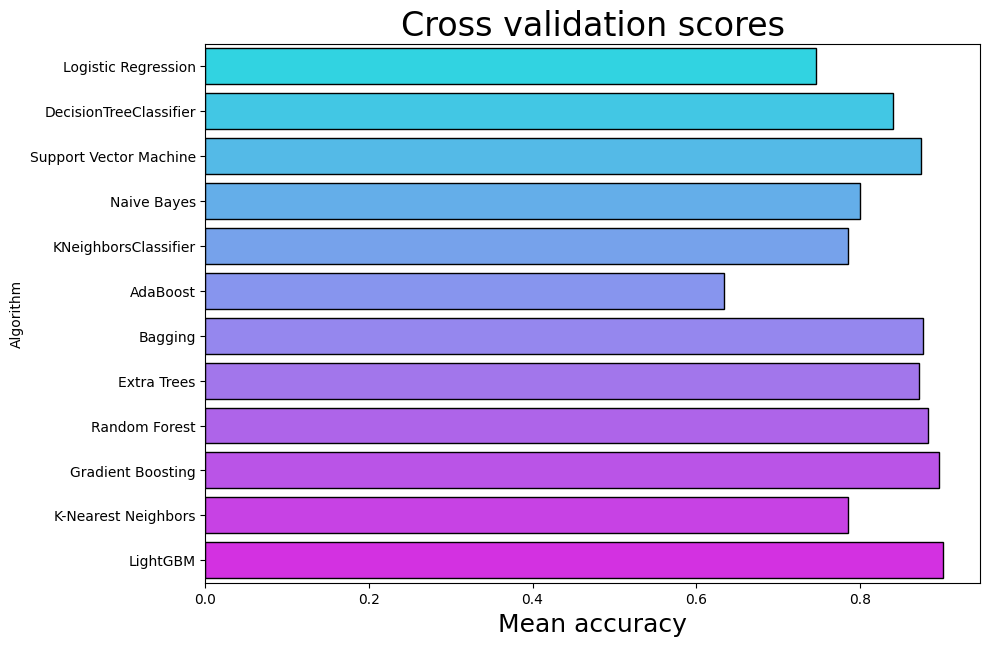

In [80]:
cv_df=perform_cross_validation(modelos, X_train_fs, y_train)

In [81]:
cv_df

,CrossVal_Score_Means,CrossValerrors,Algorithm
0,0.75,0.01,Logistic Regression
1,0.84,0.01,DecisionTreeClassifier
2,0.88,0.01,Support Vector Machine
3,0.80,0.01,Naive Bayes
4,0.79,0.01,KNeighborsClassifier
5,0.63,0.07,AdaBoost
6,0.88,0.01,Bagging
7,0.87,0.01,Extra Trees
8,0.88,0.01,Random Forest
9,0.90,0.01,Gradient Boosting


# Elegir hiperparámetros: Fine tuning



In [ ]:
# Según el volumen de datos y sus tipos


In [ ]:
results_df = hyperparameter_tuning(models_df, X_train, y_train)

In [ ]:
best_params=results_df.loc[results_df['Best Score']==max(results_df['Best Score']),'Best Parameters'].to_dict()[0]
best_model_name=results_df.loc[results_df['Best Score']==max(results_df['Best Score']),'Model'].to_dict()[0]
best_model=modelos.get(best_model_name)

In [ ]:
model_tuned=best_model.set_params(**best_params)
model_tuned.fit(X_train,y_train)
y_pred=model_tuned.predict(X_val)
recall_score(y_val,y_pred,average='macro')

# Validación


In [ ]:
# Dependerá de cada modelo. Ejecutamos


In [ ]:
plot_confusion_matrix(y_val, y_pred)

In [ ]:
cross_validation_with_confusion_matrix(model_tuned, X_val, y_val, nsplits=10)

# Prestaciones del modelo


In [ ]:
Classification_report = pd.DataFrame.from_dict(classification_report(y_val, y_pred, output_dict=True)).T
Classification_report

### ROC Curve y Area Under the Curve (AUC)

In [ ]:
# Llama a la función con tu modelo y datos de validación
plot_roc_curve(model_tuned, X_val, y_val)


In [ ]:
generate_roc_auc(model_tuned, X_train, y_train, X_val, y_val)

## Análisis de overfitting

In [ ]:

test_size_coef=0.2
cv=5
train_sizes=np.linspace(0.1, 1.0, 10)
scoring='recall_macro'

In [ ]:
t_size=0.15
perc_pca=0.95
thresh_norm=0.05
steps=5
score='recall_macro'

In [ ]:

train_sizes, train_scores, test_scores=learning_curve(model_tuned, X_train, y_train, cv=ShuffleSplit(n_splits=50, test_size=t_size, random_state=0), n_jobs=-1, train_sizes=np.linspace(0.1, 1.0,steps), scoring=score)
display = LearningCurveDisplay(train_sizes=train_sizes,
    train_scores=train_scores, test_scores=test_scores, score_name=score)
display.plot()
plt.show()

# 21. Bonus Track